In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
! pip install tensorflow_datasets

In [3]:
dataset,info = tfds.load('cats_vs_dogs',with_info=True,as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.OCW8NP_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

In [5]:
class_names = info.features['label'].names
class_names

['cat', 'dog']

In [6]:
for i, example in enumerate(dataset['train']):
  #example = ('image','label')
  image,label=example
  save_dir = './cats_vs_dogs/train/{}'.format(class_names[label])
  os.makedirs(save_dir,exist_ok=True)

  filename = save_dir + "/" + "{}_{}.jpg".format(class_names[label],i)
  tf.keras.preprocessing.image.save_img(filename,image.numpy())


In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D,Flatten,Dense,MaxPooling2D,Dropout,BatchNormalization

In [8]:
from tensorflow.keras.models import Sequential

In [63]:
datagen = ImageDataGenerator(rescale=1/255,validation_split=0.2,rotation_range=10,
                             width_shift_range=0.1,height_shift_range=0.1,
                             shear_range=0.1,zoom_range=0.1,horizontal_flip=True)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    '/content/cats_vs_dogs/train',
    target_size=(150,150),
    batch_size=64,
    class_mode='binary',
    subset = 'training'
)
validation_gen = val_datagen.flow_from_directory(
    '/content/cats_vs_dogs/train',
    target_size=(150,150),
    batch_size=64,
    class_mode='binary',
    subset = 'validation',
    shuffle=False
)

Found 18611 images belonging to 2 classes.
Found 4651 images belonging to 2 classes.


In [21]:
from tensorflow.keras.layers import GlobalAveragePooling2D

model = Sequential()

model.add(Conv2D(32,kernel_size=3,activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.2))

model.add(Conv2D(64,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128,kernel_size=3,activation='relu'))
model.add(MaxPooling2D(2))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(GlobalAveragePooling2D())
model.add(Dropout(0.6))
model.add(Dense(128,activation='relu'))

model.add(Dense(1,activation='sigmoid'))




/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
from tensorflow.keras.callbacks import EarlyStopping

early = EarlyStopping(
    monitor='val_loss',
    patience=6,
    restore_best_weights=True
)

from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6
)



In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 74, 74, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 36, 36, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 17, 17, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,785 (432.75 KB)

 Trainable params: 110,337 (431.00 KB)

 Non-trainable params: 448 (1.75 KB)

In [24]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(train_gen.classes)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes = np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print('class weights dictionary: ',class_weights_dict)


class weights dictionary:  {0: np.float64(0.9976948643722526), 1: np.float64(1.0023158121499354)}


In [25]:
print(train_gen.class_indices)
print(validation_gen.class_indices)


{'cat': 0, 'dog': 1}
{'cat': 0, 'dog': 1}


In [44]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

history = model.fit(train_gen,epochs=20,validation_data=validation_gen, callbacks=[early, reduce_lr])

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 140s 449ms/step - accuracy: 0.7592 - loss: 0.4987 - val_accuracy: 0.7381 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 125s 429ms/step - accuracy: 0.7822 - loss: 0.4707 - val_accuracy: 0.6953 - val_loss: 0.6541 - learning_rate: 0.0010
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 130s 446ms/step - accuracy: 0.7819 - loss: 0.4629 - val_accuracy: 0.7192 - val_loss: 0.6017 - learning_rate: 0.0010
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 132s 454ms/step - accuracy: 0.8053 - loss: 0.4292 - val_accuracy: 0.8031 - val_loss: 0.4351 - learning_rate: 5.0000e-04
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 132s 454ms/step - accuracy: 0.8188 - loss: 0.4053 - val_accuracy: 0.7811 - val_loss: 0.4836 - learning_rate: 5.0000e-04
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 129s 443ms/step - accuracy: 0.8201 - loss: 0.3969 - val_accuracy: 0.8097 - val_loss: 0.4139 - learning_rate: 5.0000e-04
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 129s 444ms/s

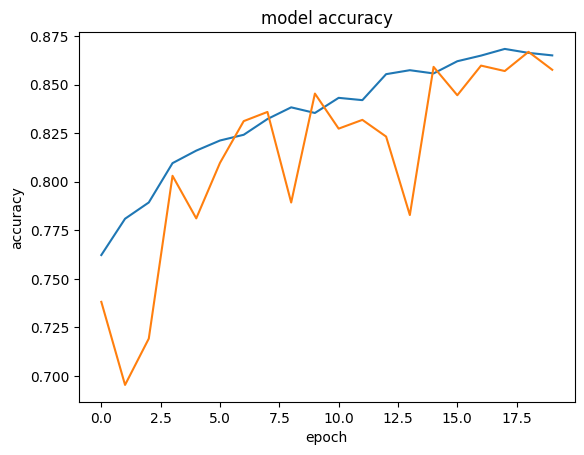

In [45]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [46]:
model.save("cats_vs_dogs.h5")

In [47]:
model_load = tf.keras.models.load_model("cats_vs_dogs.h5")

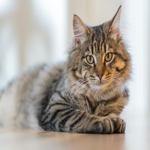

In [48]:
import requests
from  PIL import Image
from tensorflow.keras.preprocessing import image

img_url ="https://images.pexels.com/photos/177809/pexels-photo-177809.jpeg"
img = Image.open(requests.get(img_url,stream=True).raw)
img = img.resize((150,150))
img


In [49]:
img_array = image.img_to_array(img)

In [50]:
img = np.expand_dims(img_array,axis=0)


In [51]:
img = img/255

In [52]:
prediction = model.predict(img)
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 505ms/step


array([[0.00378592]], dtype=float32)

In [53]:
TH = 0.5
pred_idx = int(prediction[0][0]>TH)
classes = {v:k for k,v in train_gen.class_indices.items()}
classes[pred_idx]

'cat'

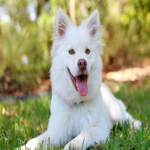

In [54]:
img_url1 ="https://images.pexels.com/photos/356378/pexels-photo-356378.jpeg"
img1 = Image.open(requests.get(img_url1,stream=True).raw)
img1 = img1.resize((150,150))
img1

In [55]:
img_array1 = image.img_to_array(img1)
img1 = np.expand_dims(img_array1,axis=0)
img1 = img1/255
prediction1 = model.predict(img1)
print(prediction1)
TH = 0.5
pred_idx1 = int(prediction1[0][0]>TH)
classes = {v:k for k,v in train_gen.class_indices.items()}
classes[pred_idx1]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.9124981]]


'dog'

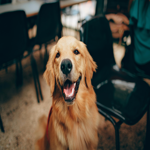

In [56]:
img_url2 ="https://images.pexels.com/photos/2253275/pexels-photo-2253275.jpeg"
img2 = Image.open(requests.get(img_url2,stream=True).raw)
img2 = img2.resize((150,150))
img2

In [57]:
img_array2 = image.img_to_array(img2)
img2 = np.expand_dims(img_array2,axis=0)
img2 = img2/255
prediction2 = model.predict(img2)
print(prediction2)
TH = 0.5
pred_idx2 = int(prediction2[0][0]>TH)
classes = {v:k for k,v in train_gen.class_indices.items()}
classes[pred_idx2]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[0.96894896]]


'dog'

In [64]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

validation_gen.reset()

y_true = validation_gen.classes


In [65]:
y_pred_prob = model.predict(validation_gen)
y_pred = (y_pred_prob > 0.5).astype(int)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


73/73 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step


In [66]:
cm = confusion_matrix(y_true, y_pred)
print(cm)


[[2129  202]
 [ 417 1903]]


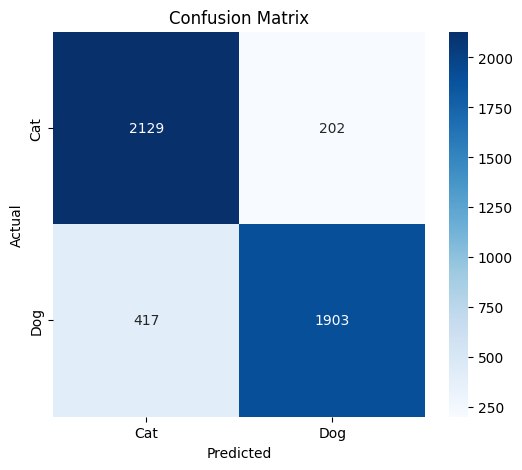

In [67]:
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cat','Dog'],
            yticklabels=['Cat','Dog'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [68]:
from sklearn.metrics import classification_report

print(classification_report(
    y_true,
    y_pred,
    target_names=['Cat', 'Dog']
))


              precision    recall  f1-score   support

         Cat       0.84      0.91      0.87      2331
         Dog       0.90      0.82      0.86      2320

    accuracy                           0.87      4651
   macro avg       0.87      0.87      0.87      4651
weighted avg       0.87      0.87      0.87      4651



In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.8669103418619651
Precision: 0.9040380047505938
Recall: 0.8202586206896552
F1 Score: 0.8601129943502824


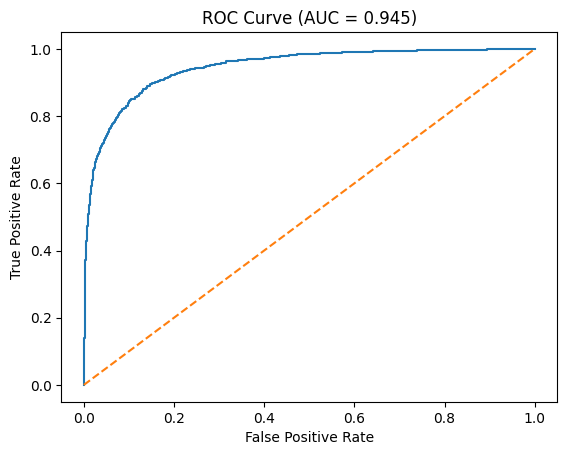

AUC Score: 0.9447676740780186


In [70]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_prob = y_pred_prob.ravel()

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob)
auc_score = roc_auc_score(y_true, y_pred_prob)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC = {auc_score:.3f})")
plt.show()

print("AUC Score:", auc_score)


In [72]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [73]:
model.save('/content/drive/MyDrive/cats_vs_dogs_model.keras')
